In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dedalus import public as de
import logging
logger = logging.getLogger(__name__)
%matplotlib inline

def Eigenmodes_solver(N, k, beta, L):
    """
    Solve for the growthrates and eigenmodes.
     
    Parameters
    ----------
    N : int
        Grid resolution
    k : real
        Alongshore wavenumber
    L : real
        Width of channel
    """

    y_basis = de.Chebyshev('y', N, interval=(0, L))
    domain = de.Domain([y_basis], grid_dtype=np.complex128)

    problem = de.EVP(domain, variables=['u','v','eta'], eigenvalue='omega')

    problem.parameters['k'] = k
    problem.parameters['beta'] = beta
    problem.substitutions['f'] = "(1 + beta*y)"
    problem.substitutions['dt(A)'] = "-1j*omega*A"
    problem.substitutions['dx(A)'] = "1j*k*A"


    #problem.substitutions['H'] = "(y)"


    problem.meta[:]['y']['dirichlet'] = True
    
    problem.add_equation("dt(u) - f*v + dx(eta) = 0")
    problem.add_equation("dt(v) + f*u + dy(eta) = 0")
    problem.add_equation("dt(eta) + dx(u) + dy(v) = 0")
   # problem.add_equation("-1j*omega*eta + 1j*k*H*u + dy(H*v) = 0")


    problem.add_bc("left(v) = 0")
    problem.add_bc("right(v) = 0")


    solver = problem.build_solver()
    solver.solve_dense(solver.pencils[0])
    
    
    # Get eigenvectors
    num_eigs = len(solver.eigenvalues)
    u = np.zeros((N,num_eigs), dtype=np.float64)
    v = np.zeros((N,num_eigs), dtype=np.float64)
    eta = np.zeros((N,num_eigs), dtype=np.float64)
    
    for i in range(num_eigs):
        solver.set_state(i)
        u[:,i] = solver.state['u']['g'].real #/ np.linalg.norm(solver.state['u']['g'].real)
        v[:,i] = solver.state['v']['g'].real #/ np.linalg.norm(solver.state['v']['g'].real)
        eta[:,i] = solver.state['eta']['g'].real #/ np.linalg.norm(solver.state['eta']['g'].real)
        
    
    # Filter infinite/nan eigenmodes
    finite = np.isfinite(solver.eigenvalues)
    solver.eigenvalues = solver.eigenvalues[finite]
    solver.eigenvectors = solver.eigenvectors[:,finite]
    u = u[:,finite]
    v = v[:,finite]
    eta = eta[:,finite]
    
    # Sort eigenmodes by eigenvalue
    order = np.argsort(solver.eigenvalues)
    solver.eigenvalues = solver.eigenvalues[order]
    solver.eigenvectors = solver.eigenvectors[:,order]
    u = u[:,order]
    v = v[:,order]
    eta = eta[:,order]
    
    eigs = np.zeros(len(solver.eigenvalues), dtype=np.complex128) 
    eigs = solver.eigenvalues
    
    return domain, solver

# This function returns the inverse delta metric (see Boyd section 7.2), 
# the eigenvalue spacing sigma for the lower resolution (that is, for eigs1),
# and an array of indices that would sort eigs1 from least to greatest.
def Inverse_Delta(eigs1, eigs2):
  
    N1 = len(eigs1)
    N2 = len(eigs2)
    tol = 1e-12
    
    o1 = np.argsort(eigs1)
    o2 = np.argsort(eigs2)
    
    scale = np.zeros(N1)
    for i in range(N1):
        p = i+1
        n = i-1
        
        if i == 0:
            scale[i] = np.abs(eigs1[o1[i]] - eigs1[o1[p]])
            while (scale[i] < tol):
                if p == N1-1:
                    print("Can't determine eigenvalue pacing for {}.".format(i))
                    break
                p += 1
                scale[i] = np.abs(eigs1[o1[i]] - eigs1[o1[p]])
                
        elif i == N1-1:
            scale[i] = np.abs(eigs1[o1[i]] - eigs1[o1[n]])
            while (scale[i] < tol):
                if n == 0:
                    print("Can't determine eigenvalue pacing for {}.".format(i))
                    break
                n -= 1
                scale[i] = np.abs(eigs1[o1[i]] - eigs1[o1[n]])
        
        else:
            t1=0
            t2= 0
            
            t1 =  np.abs(eigs1[o1[n]] - eigs1[o1[i]])
            while (t1 < tol):
                if n == 0:
                    break
                n -= 1
                t1 = np.abs(eigs1[o1[n]] - eigs1[o1[i]])
           
            t2 =  np.abs(eigs1[o1[p]] - eigs1[o1[i]])
            while (t2 < tol):
                if p == N1-1:
                    break
                p += 1
                t2 = np.abs(eigs1[o1[p]] - eigs1[o1[i]])
            
            if (t1==0 and t2 == 0):
                print("Can't determine eigenvalue pacing for {}.".format(i))
            
            scale[i] = 0.5*(t1+t2)
    
    Idelta = np.zeros(N1)
    for i in range(N1):
        diff = np.zeros(N2)
        for j in range(N2):
            diff[j] = np.abs(eigs1[o1[i]] - eigs2[o2[j]])
        
        dm = diff.min(0)
        if (dm==0):
            #print("Repeat eigenvalue between two N values: {}/{}".format(i,N1))
            dm = 1e-12
            
        Idelta[i] = scale[i]/dm
        

                
    return Idelta, scale, o1

# Uses the inverse delta metric (see Boyd section 7.2) to determine which eigenvalues
# are relatively invariant after running with higher resolution.
# A tol=1e6 means that eigenmodes will be considered good if they change less than
# one part in a million after running at a higher resolution.
def GoodEigenmodes(eigs1,eigs2, tol):
    Idelta, scale, ord1 = Inverse_Delta(eigs1,eigs2)
    
    I = 0
    good = np.full(len(Idelta), False)
    for i in range(len(Idelta)):
        if Idelta[i] > tol:
            if (np.abs(eigs1[ord1[i]]) > 1e-9): ## ignoring zero eigenvalues
                good[i] = True
                I += 1
    
    indx = np.zeros(I, dtype=np.int16)
    
    I = 0
    for i in range(len(Idelta)):
        if good[i] == True:
            indx[I] = ord1[i]
            I+=1
    
    return indx

In [2]:
l = 0
k = 2.63631578947
beta = 0.0
L = 1
tol = 1e6

NN = [32,64,(64*3)//2,128,(64*5)//2 ,(128*3)//2,(128*5)//2 ]
max_u = np.zeros(len(NN))
max_v = np.zeros(len(NN))
max_eta = np.zeros(len(NN))
eig_freq = np.zeros(len(NN))

U = [None]*len(NN)
V = [None]*len(NN)
Eta = [None]*len(NN)
Eigs = [None]*len(NN)

for i in range(len(NN)):
    N = NN[i]
    N2 = (N*3)//2
    beta = 0.01
    domain, solver =  Eigenmodes_solver(N,k,beta,L)
    domain2, solver2 =  Eigenmodes_solver(N2,k,beta,L)

    indx =  GoodEigenmodes(solver.eigenvalues,solver2.eigenvalues, tol)

    solver.eigenvalues = solver.eigenvalues[indx]
    solver.eigenvectors = solver.eigenvectors[:,indx]
    
    mpeigs = np.where(solver.eigenvalues[:]>0)[0]
    mneigs = np.where(solver.eigenvalues[:]<0)[0]
    
    solver.set_state(mpeigs[l+1])
    
    U[i] = solver.state['u']['g'].real
    V[i] = solver.state['v']['g'].real
    Eta[i] = solver.state['eta']['g'].real
    Eigs[i] = solver.eigenvalues[mpeigs[l+1]].real
    
    max_u[i] = np.abs(U[i]).max()
    max_v[i] = np.abs(V[i]).max()
    max_eta[i] = np.abs(Eta[i]).max()

2019-01-09 16:28:09,497 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-09 16:28:09,601 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-09 16:28:09,775 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-09 16:28:09,980 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-09 16:28:10,598 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-09 16:28:11,031 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-09 16:28:12,579 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-09 16:28:13,547 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-09 16:28:16,828 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-09 16:28:18,487 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-09 16:28:24,717 proble

(32, 320)

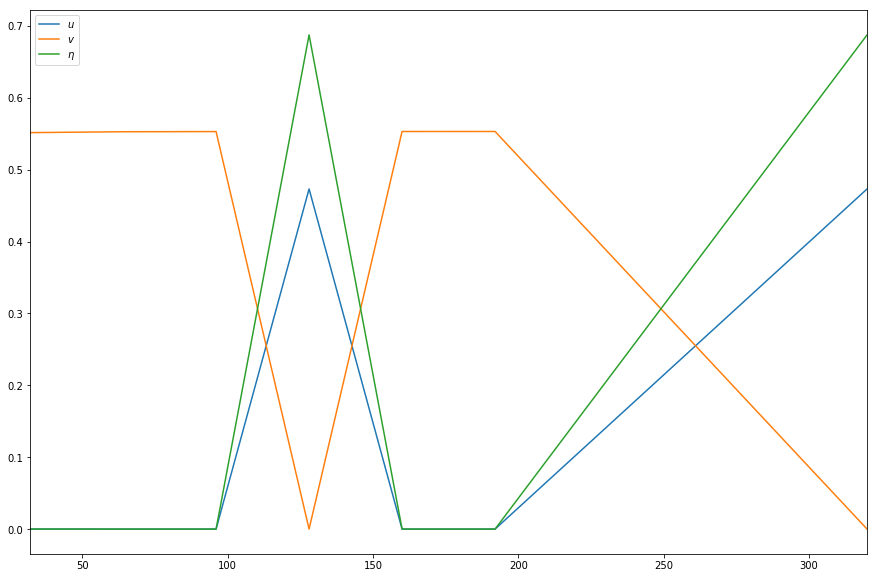

In [3]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
ax.plot(NN,max_u, label=r'$u$')
ax.plot(NN,max_v, label=r'$v$')
ax.plot(NN,max_eta, label=r'$\eta$')
ax.legend()
ax.set_xlim([NN[0],NN[-1]])

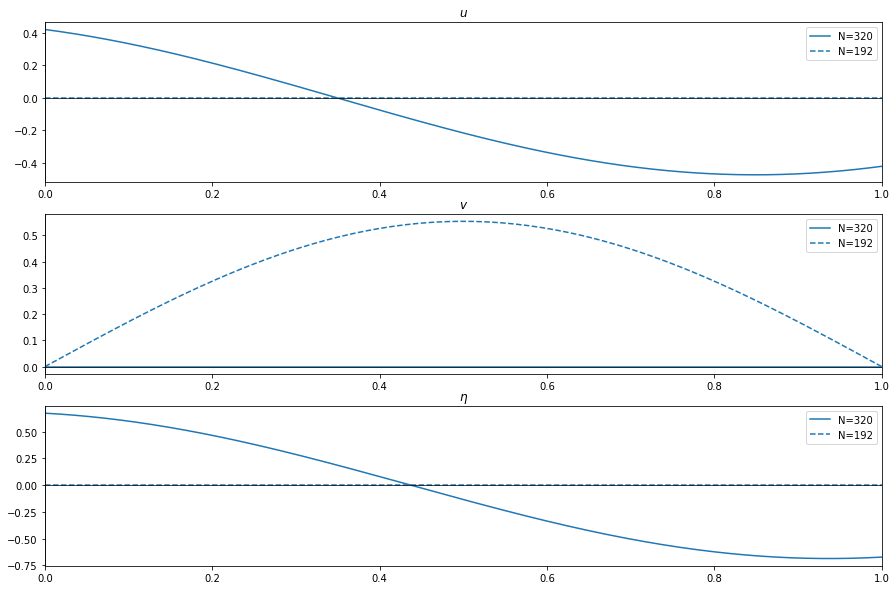

In [11]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(311)
ax1.set_title(r'$u$')
ax2 = plt.subplot(312)
ax2.set_title(r'$v$')
ax3 = plt.subplot(313)
ax3.set_title(r'$\eta$')

y_basis1 = de.Chebyshev('y', NN[-1], interval=(0, L))
domain1 = de.Domain([y_basis1], grid_dtype=np.complex128)
Y1 = domain1.grid(0, scales=domain.dealias)

y_basis2 = de.Chebyshev('y', NN[-2], interval=(0, L))
domain2 = de.Domain([y_basis2], grid_dtype=np.complex128)
Y2 = domain2.grid(0, scales=domain.dealias)

ax1.plot(Y1,U[-1],color='C0',label='N={}'.format(NN[-1]))
ax1.plot(Y2,U[-2],'--',color='C0',label='N={}'.format(NN[-2]))
ax2.plot(Y1,V[-1],color='C0',label='N={}'.format(NN[-1]))
ax2.plot(Y2,V[-2],'--',color='C0',label='N={}'.format(NN[-2]))
ax3.plot(Y1,Eta[-1],color='C0',label='N={}'.format(NN[-1]))
ax3.plot(Y2,Eta[-2],'--',color='C0',label='N={}'.format(NN[-2]))

AX = [ax1,ax2,ax3]
for ax in AX:
    ax.set_xlim([Y[0],Y[-1]])
    ax.axhline(y=0,linewidth=0.7, color='k')
    ax.axvline(x=0,linewidth=0.7, color='k')
    ax.legend()